In [109]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as pl
import pandas as pd
from scipy.interpolate import UnivariateSpline as spline
from scipy.stats import gaussian_kde as kde

Read in the recovery data for either the nominal ARF or non-nominal arfs:

In [118]:
# rec_pca=pd.read_csv('recov_pca.csv',index_col=0)
rec_pca=pd.read_csv('recov_pca_nn.csv',index_col=0)

Plot the G recovery:

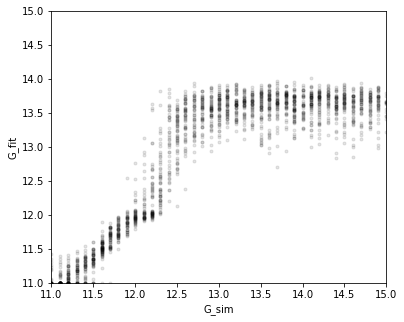

In [119]:
def plot_recov(data):
    fig=pl.figure(figsize=(6,5),facecolor='w')
    ax=pl.subplot(111)
    ax.set_xlabel('G_sim')
    ax.set_ylabel('G_fit')
    ax.set_xlim(11,15)
    ax.set_ylim(11,15)
    pl.plot(data['g_sim'],data['g_fit'],marker='.',ls='none',color='k',alpha=0.1)

plot_recov(rec_pca)
pl.show()

1:1 line where recovery is good, points clustered around G = 14 (~ the middle of the none-detection parameter space) when recovery is bad.

95% limit means that if we input a spectrum and the ANN says there is no evidence for axions (G_fit>G_threshold), we can be 95% confident that the true value of G (i.e. G_sim) is above that limit, i.e. there is a 5% chance that G_sim is < G_limit, with no prior on what G actually is.

First determine a non-detection threshold, by plotting the distribution of definite non-detections:

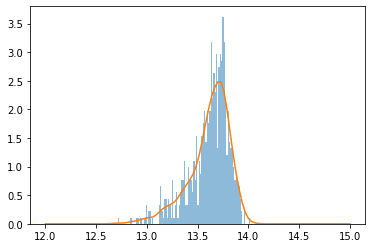

In [120]:
# plot histogram
pl.hist(rec_pca['g_fit'][rec_pca['g_sim']>13.5],bins=100,alpha=0.5,density=True)

# define kernel density estimate
density=kde(rec_pca['g_fit'][rec_pca['g_sim']>13.5])
gs=np.linspace(12,15,100)
pl.plot(gs,density.pdf(gs))

pl.show()

If we define a non-detection threshold as the 99.9% lower limit of this distribution, we can find this from the CDF:

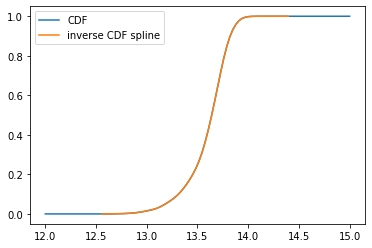

G_threshold: 12.71890896536729


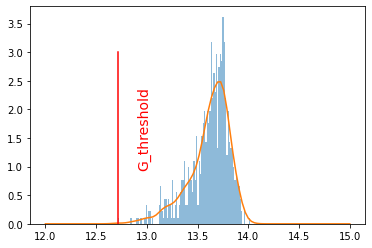

In [121]:
cdf=np.cumsum(density.pdf(gs))
cdf=cdf/max(cdf)

pl.plot(gs,cdf,label='CDF')

# invert the CDF to find the 0.001% percentile:
inv_cdf=spline(cdf[(cdf>1e-5) &  (cdf<1)],gs[(cdf>1e-5) &  (cdf<1)],s=0)
pl.plot(inv_cdf(cdf),cdf,label='inverse CDF spline')

pl.legend()
pl.show()

G_threshold=inv_cdf(0.001)
print('G_threshold:',G_threshold)


pl.hist(rec_pca['g_fit'][rec_pca['g_sim']>13.5],bins=100,alpha=0.5,density=True)
pl.plot(gs,density.pdf(gs))
pl.plot([G_threshold,G_threshold],[0,3],color='r')
pl.text(12.9,1,'G_threshold',color='r',fontsize=14,rotation=90)

pl.show()

We can plot this limit on the graph, check it makes sense. Note that this is not our 95% upper limit, this is the threshold we are using for detections/non-detections.

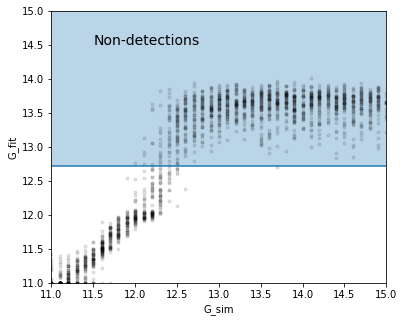

In [122]:
plot_recov(rec_pca)
pl.plot([11,15],[G_threshold,G_threshold])
pl.fill_between([11,15],[G_threshold,G_threshold],[15,15],alpha=0.3)
pl.text(11.5,14.5,'Non-detections',fontsize=14)
pl.show()

Now, we want the value of G_limit where P(G_sim < G_limit) = 0.05, given that G_fit>G_threshold.

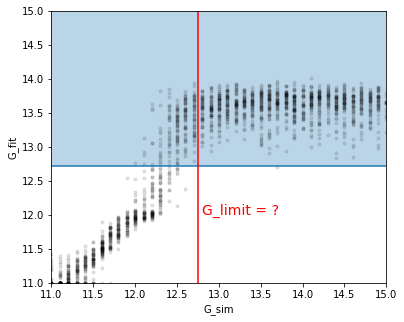

In [123]:
plot_recov(rec_pca)
pl.plot([11,15],[G_threshold,G_threshold])
pl.fill_between([11,15],[G_threshold,G_threshold],[15,15],alpha=0.3)
pl.plot([12.75,12.75],[11,15],color='r')
pl.text(12.8,12,'G_limit = ?',color='r',fontsize=14)
pl.show()


The problem is, calculating this by looking at the distribution of G_sim means that it depends on the parameter space G_sim covers. This may actually be technically correct (i.e. it's the Bayesian solution), but it doesn't correspond directly to the xspec limit. We can calculate an alternative limit by looking for the value of G_sim where there is a 95% chance of a non-detection - i.e. if G was this value, there is a 5% chance that we would detect it, and 95% chance that we would not.

A simple histogram of the fraction of points that are non-detections gives us a rough idea:

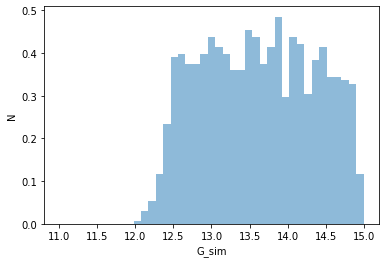

In [124]:
ax=pl.subplot(111)
ax.set_xlabel('G_sim')
ax.set_ylabel('N')
pl.hist(rec_pca['g_sim'][rec_pca['g_fit']>G_threshold],alpha=0.5,bins=np.linspace(11,15,42),density=True)
pl.show()

We can do this more neatly by calculating the Gaussian KDE at each G_sim, then integrating below the detection limit:

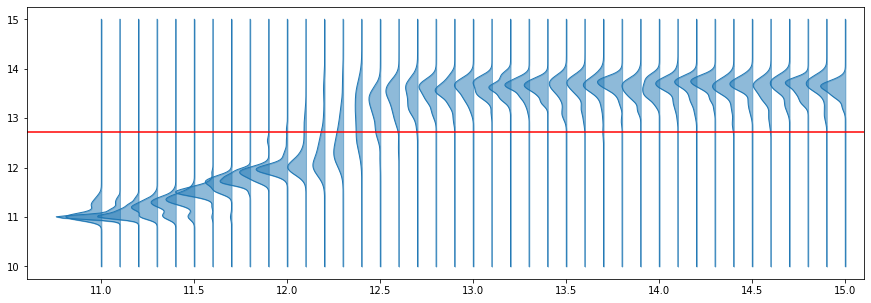

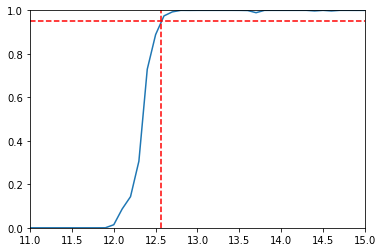

95% limit: 12.565


In [125]:

# find the set of G_sim values:
g_sim_vals=np.array(sorted(list(set(rec_pca['g_sim']))))

# find the distributions of g_fit in each case:
kdes=[]
for g_sim in g_sim_vals:
    temp_vals=rec_pca['g_fit'][rec_pca['g_sim']==g_sim]
    kdes.append(kde(rec_pca['g_fit'][rec_pca['g_sim']==g_sim]))

fig1=pl.figure(figsize=(15,5))
ax1=pl.subplot(111)
ax1.set_xlim(10.6,15.1)


# plot all the kdes:
ys=np.linspace(10,15,200)
for g,temp_kde in zip(g_sim_vals,kdes):
    xs=-0.05*temp_kde(ys)+g
    pl.plot(xs,ys,color='C0',lw=1)
    pl.fill_betweenx(ys,xs,g,color='C0',alpha=0.5)

# plot detection limit:
pl.plot([10,16],[G_threshold,G_threshold],color='r')

# integrate each kde below the detection limit:
fractions=[]
for temp_kde in kdes:
    fractions.append(temp_kde.integrate_box_1d(10,G_threshold))
fractions=np.array(fractions)

# fit a spline to this to get a smooth curve:
frac_spline=spline(g_sim_vals[(g_sim_vals>12.5)],fractions[(g_sim_vals>12.5)],k=3,s=0)

# plot detect % as a function of G_sim:
fig2=pl.figure()
ax2=pl.subplot(111)
ax2.set_ylim(0,1)
ax2.set_xlim(11,15)
pl.plot(g_sim_vals,1-fractions,color='C0')

# plot 95% limit:
pl.plot([11,15],[0.95,0.95],color='r',ls='dashed')

# find intersection:
frac_spline=spline(g_sim_vals,1-fractions-0.95,s=0)
limit95=frac_spline.roots()[0]

pl.plot([limit95,limit95],[0,1],color='r',ls='dashed')
pl.show()

print('95% limit:',str(limit95)[:6])
